# Fetal ECG Extraction from Single-Channel Maternal ECG Using Singular Value Decomposition

> Partha Pratim Kanjilal,* Member, ZEEE, Sarbani Palit, Member, ZEEE, and Goutam Saha

Experiments are based on public dataset ADFECGDB

## Outline of the Extraction Procedure

### 1. Separation of the mECG component from the composite signal
The data are first arranged in the form of a matrix $A$ such that the consecutive maternal ECG cycles occupy the consecutive rows, and the peak maternal component lies in the same column. SVD is performed on $A$, and $A_M = u_1 \sigma_1 (v_1)^T$ is separated from $A$, forming $A_{R1}=A-A_M$

### 2. Extraction of the fECG component
The time series formed from the successive rows of $A_{R1}$ will contain the fECG component along with noise; this series is rearranged into a matrix $B$ such that each row contains one fetal ECG cycle, with the peak value lying in the same column. SVD is performed on $B$, from which the most dominant component $u_1 \sigma_1 (v_1)^T$ is extracted, which will give the desiderd fECG component.

## Mechanism of Fetal ECG Extraction

### Method 1
The most commonly occurring period length for the mECG is considered to be the row lenght ($n$) of the data matrix $A$. The consecutive periods with respect to mECG cycles are aligned into the consecutive rows of $A$, and linearly interpolated data are used for the periods shorter than n. The row length of matrix $B$ is also decided similarly with respect to the fECG cycles. The part of the data in $u_1 \sigma_1 (v_1)^T$ that corresponds to the interpolated data in $A$ or $B$ is eliminated while forming the extracted mECG and the fECG series.

### Method 2
The most likely periodic length (in terms of energy) of the most dominant periodic component present in the signal is considered to be the row lengths of the data matrices $A$ and $B$. The SVR spectrum of the composite maternal ECG signal is used to determine the period length (say $n$) of the mECG component in the composite signal. The periodic segments which are not equal to $n$ in length, are compressed or expanded to the length $n$ as follows.

The data segment $y(1), y(2), ..., y(n^*)$, can be replaced by the set $x(1), x(2), ..., x(n)$ where $n \ne n^*$, using the transformation

$$x(j) = y(j^*) + (y(j^* + 1) - y(j^*))(r_j - j^*)$$

where $r_j = (j - 1)(n^* - 1)/(n - 1) + 1$, and $j^*$ is the integral part of $r_j$. Thus the successive (pseudo-)periods of the composite ECG series $\{y( \cdot )\}$ are converted into data lengths having the same period length $n$, which are now aligned in the rows of the matrix $A$. Appropriate reverse transformation is performed on the data at the time of reconstruction of the extracted mECG series.

The period length of the fECG component is determined from the SVR spectrum of the residual series. The subsequent steps for arranging data into $B$ are the same as above.

### Method 3
Once the $m \times n$ data matrix $A$ is formed, an $m_1 \times n$ ($m_1 \le m$) matrix $\tilde{A}$ is assumed to move over $A$ such that the first row is dropped and a new row is appended for successive locations of the window. $\tilde{A}$ is SV-decomposed, and the last row of $u_1 \sigma_1 (v_1)^T$ is assumed to be the extracted mECG component corresponding to the last row of $\tilde{A}$, which is subtracted from the original composite ECG series. The residual series id arranged into $B$, from which the fECG component is extracted the same way as the mECG component. This scheme is particularly applicable when sufficient amount of data are available.

In [120]:
import pyedflib
import pandas as pd
import matplotlib.pyplot as plt
import neurokit2 as nk

## Load data

Channels: ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']
Sampling frequency: 1000.0


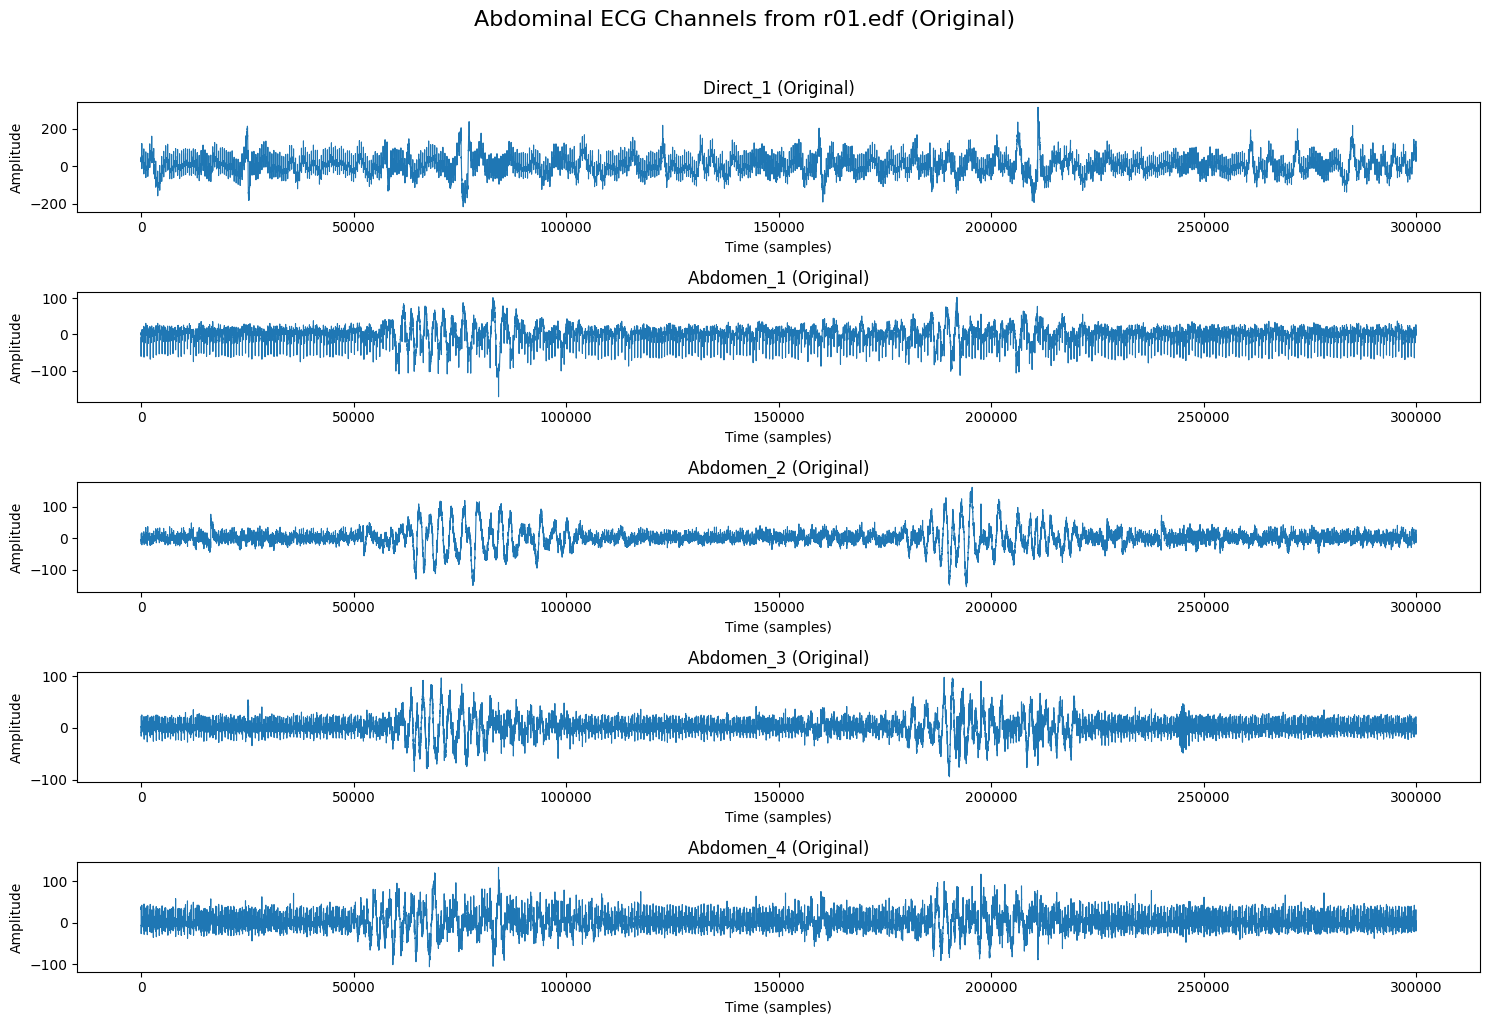

In [121]:
# Load EDF file
edf_path = "../data/raw/r01.edf"
edf = pyedflib.EdfReader(edf_path)

# Get metadata
n_channels = edf.signals_in_file
channel_labels = edf.getSignalLabels()
signal_freq = edf.getSampleFrequency(0)

print("Channels:", channel_labels)
print("Sampling frequency:", signal_freq)

signals = [edf.readSignal(i) for i in range(n_channels)]
df = pd.DataFrame({label: signal for label, signal in zip(channel_labels, signals)})

edf._close()

channels = ['Direct_1', 'Abdomen_1', 'Abdomen_2', 'Abdomen_3', 'Abdomen_4']

plt.figure(figsize=(15, 10))

for i, channel in enumerate(channels):
    # cleaned = nk.ecg_clean(df[channel], sampling_rate=signal_freq)
    plt.subplot(5, 1, i + 1)
    plt.plot(df[channel], linewidth=0.8) # try also with cleaned
    plt.title(f"{channel} (Original)")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")

plt.suptitle("Abdominal ECG Channels from r01.edf (Original)", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


## Method 1

### Extract mECG

> A maternal heart rate (mHR), measured by an electrocardiogram (ECG), generally falls between 60 and 100 bpm at rest. 

(#beats, #samples) = (412, 727)


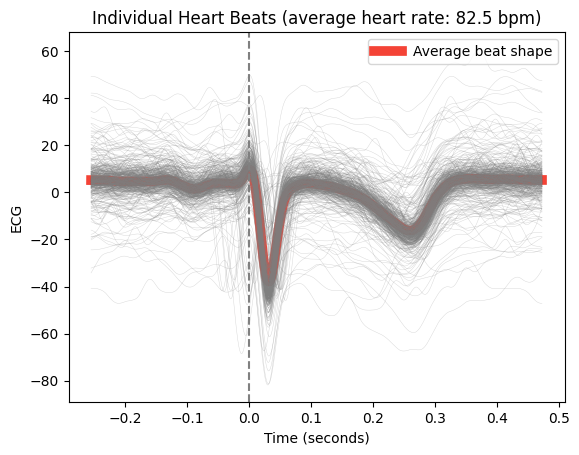

In [122]:
# Let's perform the experiment on Abdomen_1 channel
# ecg_segment segments an ECG signal into single heartbeats
raw_signal = df['Abdomen_1'].values
cleaned_signal = nk.ecg_clean(raw_signal, sampling_rate=1000)
qrs_epochs = nk.ecg_segment(cleaned_signal, rpeaks=None, sampling_rate=1000, show=True)

A = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in qrs_epochs.items()
}).T  # Transpose to shape (n_beats, n_samples)

print("(#beats, #samples) =", A.shape)

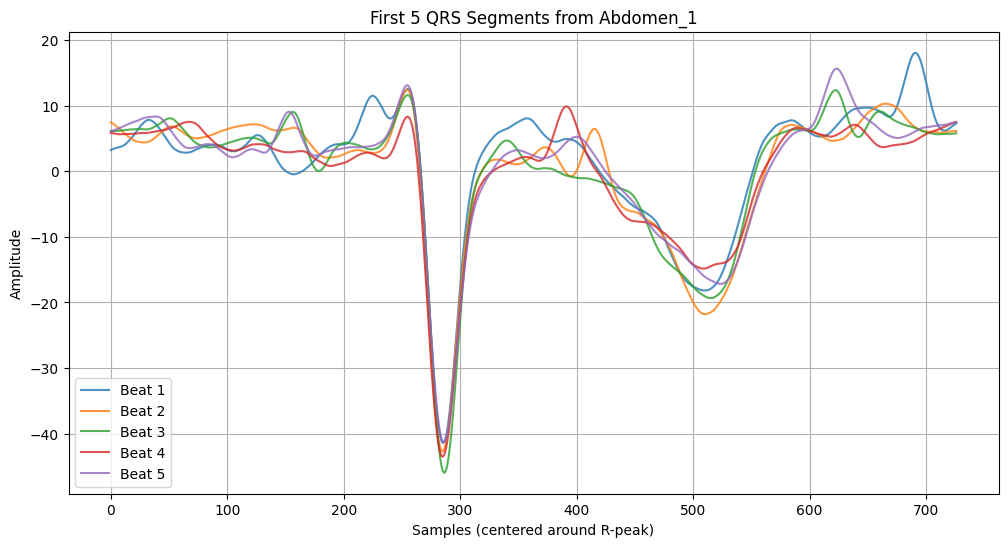

In [123]:
# Plot first 5 QRS segments
plt.figure(figsize=(12, 6))

for i in range(5):
    plt.plot(A.iloc[i], label=f'Beat {i+1}', alpha=0.8)

plt.title("First 5 QRS Segments from Abdomen_1")
plt.xlabel("Samples (centered around R-peak)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()


In [124]:
import numpy as np

if A.isna().any().any() or np.isinf(A.values).any():
    A = A.fillna(0)
    A = A.replace([np.inf, -np.inf], 0)
A = A.values  # Convert to NumPy array before SVD


In [125]:
U, S, VT = np.linalg.svd(A, full_matrices=False)
# Extract the dominant maternal component (rank-1 approximation)
A_M = np.outer(U[:, 0], VT[0, :]) * S[0]
# Compute the residual matrix by subtracting maternal component from A
A_residual = A - A_M

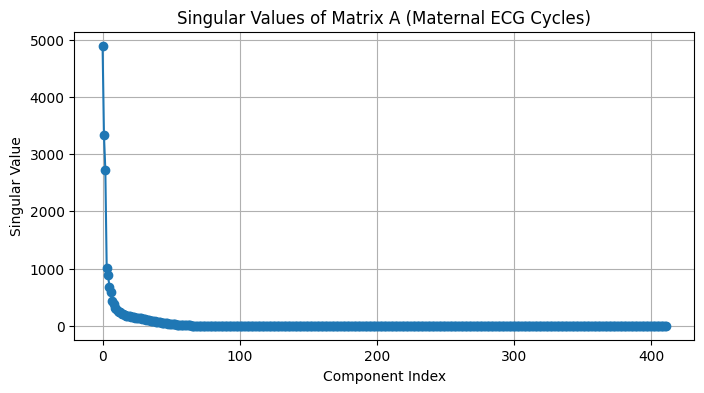

In [126]:
plt.figure(figsize=(8, 4))
plt.plot(S, marker='o')
plt.title("Singular Values of Matrix A (Maternal ECG Cycles)")
plt.xlabel("Component Index")
plt.ylabel("Singular Value")
plt.grid(True)
plt.show()


### Extract fECG

> The normal fetal heart rate (FHR) typically ranges from 110 to 160 beats per minute (bpm).

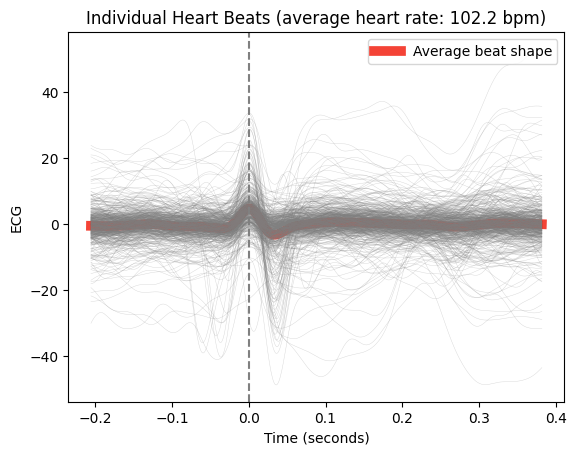

In [127]:
# Now we flatten the residual signal and we do again the segmentation
residual_signal = A_residual.flatten()
cleaned_signal = nk.ecg_clean(residual_signal, sampling_rate=1000)
fetal_qrs_epochs = nk.ecg_segment(cleaned_signal, rpeaks=None, sampling_rate=1000, show=True)

B = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in fetal_qrs_epochs.items()
}).T.values

if np.isnan(B).any() or np.isinf(B).any():
    B = np.nan_to_num(B)

U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)
# Dominant fetal ECG component (rank-1 approximation)
B_F = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]
# Compute the residual matrix by subtracting fetal component from residual
B_residual = B - B_F

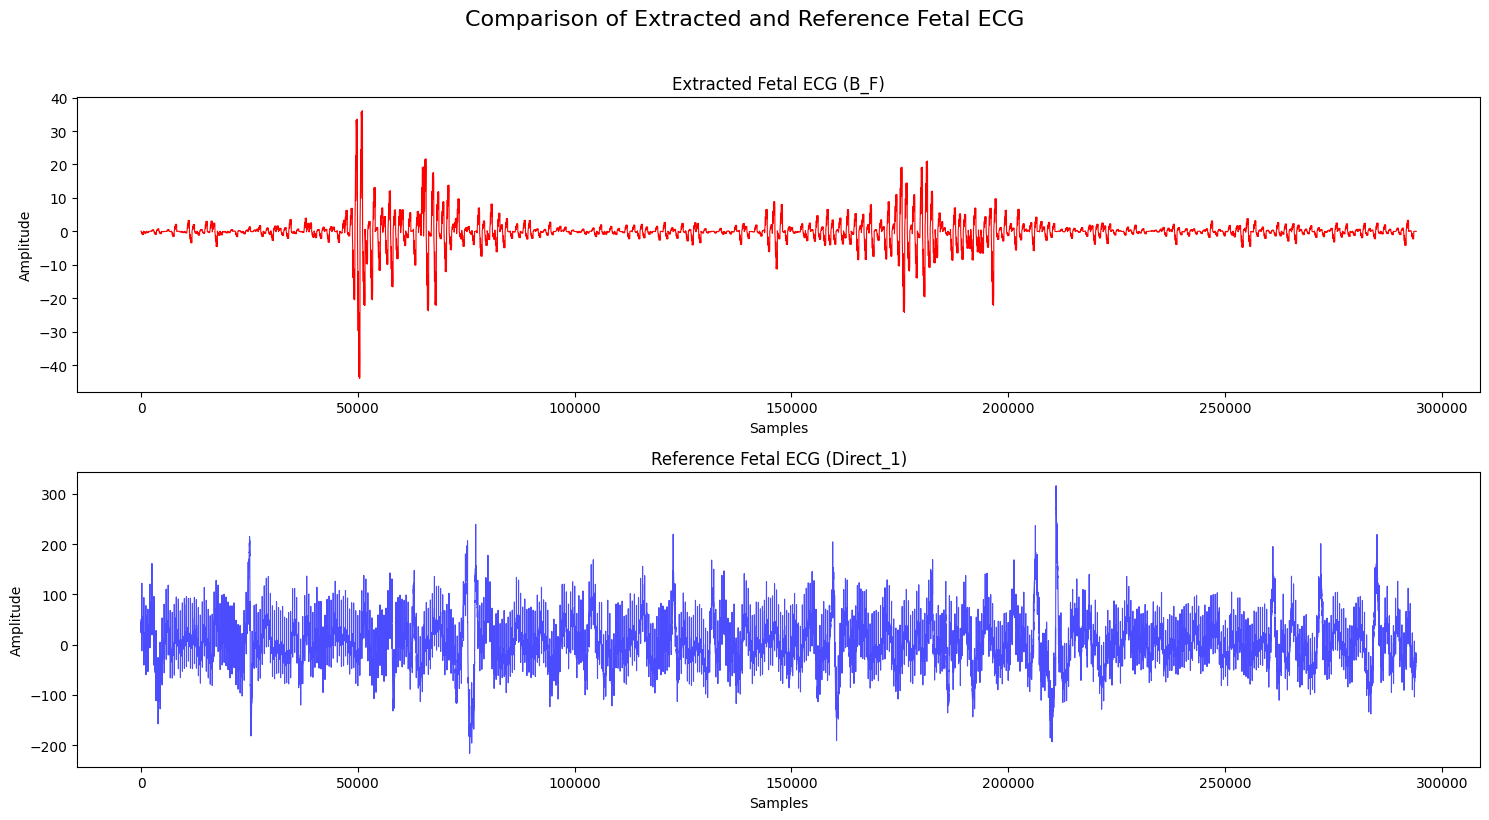

In [128]:
# Flatten extracted fetal ECG cycles
fecg_flat = B_F.flatten()

# Extract corresponding segment from df['Direct_1']
direct1_signal = df['Direct_1'].values
direct1_segment = direct1_signal[:len(fecg_flat)]

plt.figure(figsize=(15, 8))

# Plot Extracted Fetal ECG
plt.subplot(2, 1, 1)
plt.plot(fecg_flat, color='red', linewidth=0.8)
plt.title("Extracted Fetal ECG (B_F)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

# Plot Reference Fetal ECG (Direct_1)
plt.subplot(2, 1, 2)
plt.plot(direct1_segment, color='blue', alpha=0.7, linewidth=0.8)
plt.title("Reference Fetal ECG (Direct_1)")
plt.xlabel("Samples")
plt.ylabel("Amplitude")

plt.suptitle("Comparison of Extracted and Reference Fetal ECG", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()


### Extract another ECG from the last residual matrix

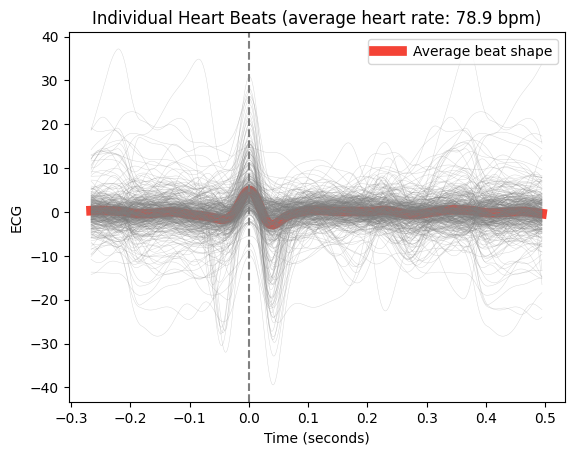

In [129]:
# Again, we flatten the residual signal and we do the segmentation
residual_signal = B_residual.flatten()
cleaned_signal = nk.ecg_clean(residual_signal, sampling_rate=1000)
fetal_qrs_epochs = nk.ecg_segment(cleaned_signal, rpeaks=None, sampling_rate=1000, show=True)

B = pd.DataFrame({
    beat_id: epoch["Signal"].values
    for beat_id, epoch in fetal_qrs_epochs.items()
}).T.values

if np.isnan(B).any() or np.isinf(B).any():
    B = np.nan_to_num(B)

U_B, S_B, VT_B = np.linalg.svd(B, full_matrices=False)
# Dominant secondary fetal ECG component (rank-1 approximation)
B_F2 = np.outer(U_B[:, 0], VT_B[0, :]) * S_B[0]

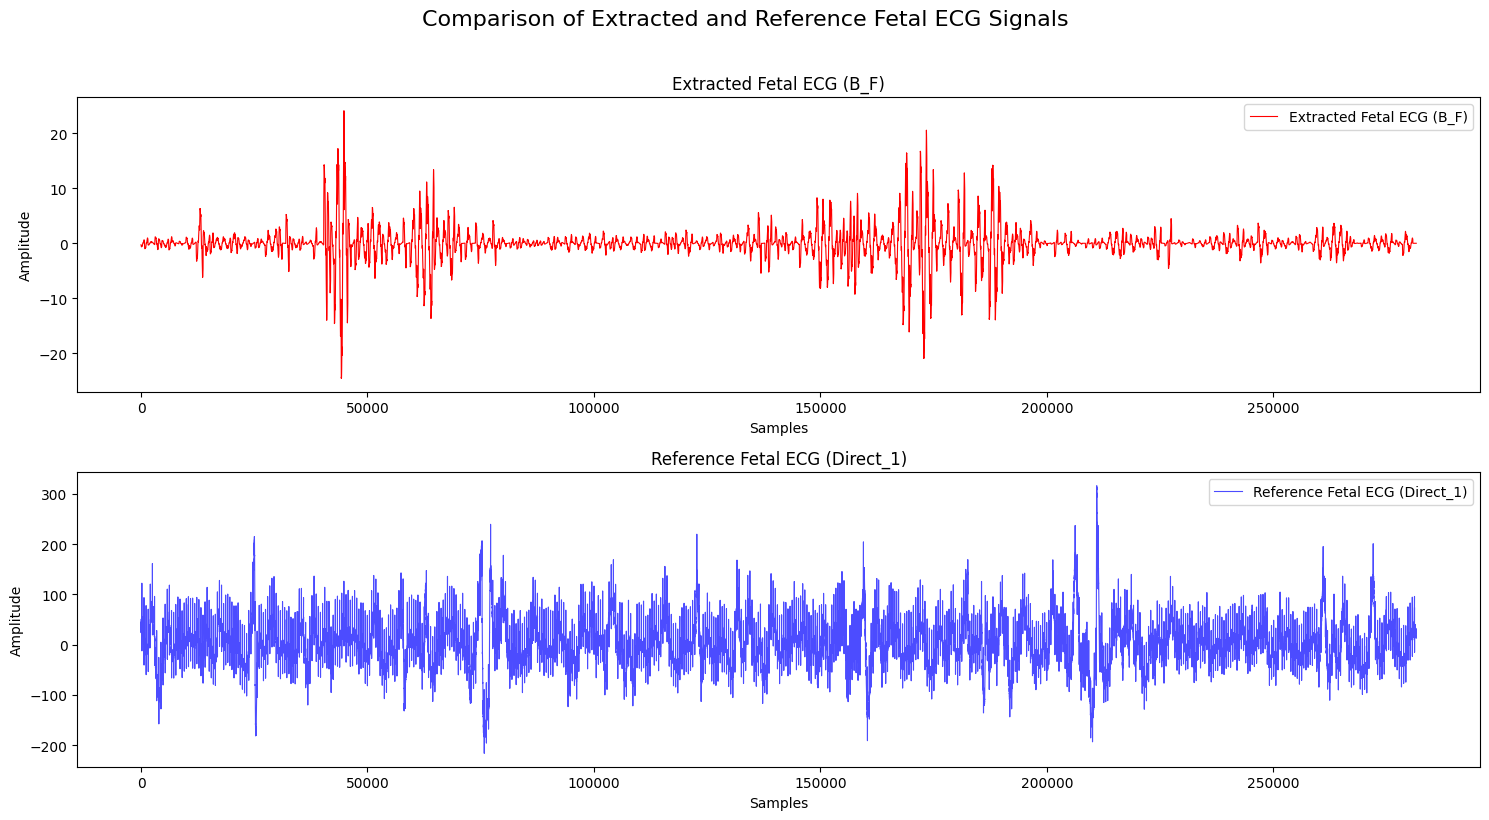

In [130]:
# Flatten extracted fetal ECG cycles
fecg_flat = B_F2.flatten()

# Extract corresponding segment from df['Direct_1']
direct1_signal = df['Direct_1'].values
direct1_segment = direct1_signal[:len(fecg_flat)]

plt.figure(figsize=(15, 8))

# Extracted Fetal ECG (B_F)
plt.subplot(2, 1, 1)
plt.plot(fecg_flat, label='Extracted Fetal ECG (B_F)', color='red', linewidth=0.8)
plt.title('Extracted Fetal ECG (B_F)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

# Reference Fetal ECG (Direct_1)
plt.subplot(2, 1, 2)
plt.plot(direct1_segment, label='Reference Fetal ECG (Direct_1)', color='blue', alpha=0.7, linewidth=0.8)
plt.title('Reference Fetal ECG (Direct_1)')
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.legend()

plt.suptitle("Comparison of Extracted and Reference Fetal ECG Signals", fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

## Method 2